In [1]:
from os.path import dirname

import pandas as pd
import numpy as np
from sklearn import preprocessing
from Classifiers.OS_CNN.OS_CNN_easy_use import OS_CNN_easy_use
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils.dataloader.TSC_data_loader import TSC_data_loader
from dataset_types import long_dataset_name_list, short_dataset_name_list, all_dataset_name_list

import torch
seed = 0
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True


def set_nan_to_zero(a):
    where_are_NaNs = np.isnan(a)
    a[where_are_NaNs] = 0
    return a

In [2]:
print(len(long_dataset_name_list))
print(len(short_dataset_name_list))
print(len(all_dataset_name_list))

23
16
39


In [3]:
# Jitter, scaling, window_slice, window_warp, time_warp, rotation, magnitude_warp, spawner, wdba
# https://github.com/uchidalab/time_series_augmentation
def jitter(x, sigma=0.03):
    # https://arxiv.org/pdf/1706.00527.pdf
    return x + np.random.normal(loc=0., scale=sigma, size=x.shape)


def scaling(x, sigma=0.1):
    # https://arxiv.org/pdf/1706.00527.pdf
    factor = np.random.normal(loc=1., scale=sigma, size=(x.shape[0],x.shape[2]))
    return np.multiply(x, factor[:,np.newaxis,:])


def window_slice(x, reduce_ratio=0.9):
    # https://halshs.archives-ouvertes.fr/halshs-01357973/document
    target_len = np.ceil(reduce_ratio*x.shape[1]).astype(int)
    if target_len >= x.shape[1]:
        return x
    starts = np.random.randint(low=0, high=x.shape[1]-target_len, size=(x.shape[0])).astype(int)
    ends = (target_len + starts).astype(int)
    
    ret = np.zeros_like(x)
    for i, pat in enumerate(x):
        for dim in range(x.shape[2]):
            ret[i,:,dim] = np.interp(np.linspace(0, target_len, num=x.shape[1]), np.arange(target_len), pat[starts[i]:ends[i],dim]).T
    return ret


def window_warp(x, window_ratio=0.1, scales=[0.5, 2.]):
    # https://halshs.archives-ouvertes.fr/halshs-01357973/document
    warp_scales = np.random.choice(scales, x.shape[0])
    warp_size = np.ceil(window_ratio*x.shape[1]).astype(int)
    window_steps = np.arange(warp_size)
        
    window_starts = np.random.randint(low=1, high=x.shape[1]-warp_size-1, size=(x.shape[0])).astype(int)
    window_ends = (window_starts + warp_size).astype(int)
            
    ret = np.zeros_like(x)
    for i, pat in enumerate(x):
        for dim in range(x.shape[2]):
            start_seg = pat[:window_starts[i],dim]
            window_seg = np.interp(np.linspace(0, warp_size-1, num=int(warp_size*warp_scales[i])), window_steps, pat[window_starts[i]:window_ends[i],dim])
            end_seg = pat[window_ends[i]:,dim]
            warped = np.concatenate((start_seg, window_seg, end_seg))                
            ret[i,:,dim] = np.interp(np.arange(x.shape[1]), np.linspace(0, x.shape[1]-1., num=warped.size), warped).T
    return ret


def time_warp(x, sigma=0.2, knot=4):
    from scipy.interpolate import CubicSpline
    orig_steps = np.arange(x.shape[1])
    
    random_warps = np.random.normal(loc=1.0, scale=sigma, size=(x.shape[0], knot+2, x.shape[2]))
    warp_steps = (np.ones((x.shape[2],1))*(np.linspace(0, x.shape[1]-1., num=knot+2))).T
    
    ret = np.zeros_like(x)
    for i, pat in enumerate(x):
        for dim in range(x.shape[2]):
            time_warp = CubicSpline(warp_steps[:,dim], warp_steps[:,dim] * random_warps[i,:,dim])(orig_steps)
            scale = (x.shape[1]-1)/time_warp[-1]
            ret[i,:,dim] = np.interp(orig_steps, np.clip(scale*time_warp, 0, x.shape[1]-1), pat[:,dim]).T
    return ret


def rotation(x):
    flip = np.random.choice([-1, 1], size=(x.shape[0],x.shape[2]))
    rotate_axis = np.arange(x.shape[2])
    np.random.shuffle(rotate_axis)    
    return flip[:,np.newaxis,:] * x[:,:,rotate_axis]


def magnitude_warp(x, sigma=0.2, knot=4):
    from scipy.interpolate import CubicSpline
    orig_steps = np.arange(x.shape[1])
    
    random_warps = np.random.normal(loc=1.0, scale=sigma, size=(x.shape[0], knot+2, x.shape[2]))
    warp_steps = (np.ones((x.shape[2],1))*(np.linspace(0, x.shape[1]-1., num=knot+2))).T
    ret = np.zeros_like(x)
    for i, pat in enumerate(x):
        warper = np.array([CubicSpline(warp_steps[:,dim], random_warps[i,:,dim])(orig_steps) for dim in range(x.shape[2])]).T
        ret[i] = pat * warper

    return ret


def spawner(x, labels, sigma=0.05, verbose=0):
    # https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6983028/
    # use verbose=-1 to turn off warnings
    # use verbose=1 to print out figures
    
    import utils.dtw as dtw
    random_points = np.random.randint(low=1, high=x.shape[1]-1, size=x.shape[0])
    window = np.ceil(x.shape[1] / 10.).astype(int)
    orig_steps = np.arange(x.shape[1])
    l = np.argmax(labels, axis=1) if labels.ndim > 1 else labels
    
    ret = np.zeros_like(x)
    for i, pat in enumerate(tqdm(x)):
        # guarentees that same one isnt selected
        choices = np.delete(np.arange(x.shape[0]), i)
        # remove ones of different classes
        choices = np.where(l[choices] == l[i])[0]
        if choices.size > 0:     
            random_sample = x[np.random.choice(choices)]
            # SPAWNER splits the path into two randomly
            path1 = dtw.dtw(pat[:random_points[i]], random_sample[:random_points[i]], dtw.RETURN_PATH, slope_constraint="symmetric", window=window)
            path2 = dtw.dtw(pat[random_points[i]:], random_sample[random_points[i]:], dtw.RETURN_PATH, slope_constraint="symmetric", window=window)
            combined = np.concatenate((np.vstack(path1), np.vstack(path2+random_points[i])), axis=1)
            if verbose:
                print(random_points[i])
                dtw_value, cost, DTW_map, path = dtw.dtw(pat, random_sample, return_flag = dtw.RETURN_ALL, slope_constraint=slope_constraint, window=window)
                dtw.draw_graph1d(cost, DTW_map, path, pat, random_sample)
                dtw.draw_graph1d(cost, DTW_map, combined, pat, random_sample)
            mean = np.mean([pat[combined[0]], random_sample[combined[1]]], axis=0)
            for dim in range(x.shape[2]):
                ret[i,:,dim] = np.interp(orig_steps, np.linspace(0, x.shape[1]-1., num=mean.shape[0]), mean[:,dim]).T
        else:
            if verbose > -1:
                print("There is only one pattern of class %d, skipping pattern average"%l[i])
            ret[i,:] = pat
    return jitter(ret, sigma=sigma)


def wdba(x, labels, batch_size=6, slope_constraint="symmetric", use_window=True, verbose=0):
    # https://ieeexplore.ieee.org/document/8215569
    # use verbose = -1 to turn off warnings    
    # slope_constraint is for DTW. "symmetric" or "asymmetric"
    
    import utils.dtw as dtw
    
    if use_window:
        window = np.ceil(x.shape[1] / 10.).astype(int)
    else:
        window = None
    orig_steps = np.arange(x.shape[1])
    l = np.argmax(labels, axis=1) if labels.ndim > 1 else labels
        
    ret = np.zeros_like(x)
    for i in tqdm(range(ret.shape[0])):
        # get the same class as i
        choices = np.where(l == l[i])[0]
        if choices.size > 0:        
            # pick random intra-class pattern
            k = min(choices.size, batch_size)
            random_prototypes = x[np.random.choice(choices, k, replace=False)]
            
            # calculate dtw between all
            dtw_matrix = np.zeros((k, k))
            for p, prototype in enumerate(random_prototypes):
                for s, sample in enumerate(random_prototypes):
                    if p == s:
                        dtw_matrix[p, s] = 0.
                    else:
                        dtw_matrix[p, s] = dtw.dtw(prototype, sample, dtw.RETURN_VALUE, slope_constraint=slope_constraint, window=window)
                        
            # get medoid
            medoid_id = np.argsort(np.sum(dtw_matrix, axis=1))[0]
            nearest_order = np.argsort(dtw_matrix[medoid_id])
            medoid_pattern = random_prototypes[medoid_id]
            
            # start weighted DBA
            average_pattern = np.zeros_like(medoid_pattern)
            weighted_sums = np.zeros((medoid_pattern.shape[0]))
            for nid in nearest_order:
                if nid == medoid_id or dtw_matrix[medoid_id, nearest_order[1]] == 0.:
                    average_pattern += medoid_pattern 
                    weighted_sums += np.ones_like(weighted_sums) 
                else:
                    path = dtw.dtw(medoid_pattern, random_prototypes[nid], dtw.RETURN_PATH, slope_constraint=slope_constraint, window=window)
                    dtw_value = dtw_matrix[medoid_id, nid]
                    warped = random_prototypes[nid, path[1]]
                    weight = np.exp(np.log(0.5)*dtw_value/dtw_matrix[medoid_id, nearest_order[1]])
                    average_pattern[path[0]] += weight * warped
                    weighted_sums[path[0]] += weight 
            
            ret[i,:] = average_pattern / weighted_sums[:,np.newaxis]
        else:
            if verbose > -1:
                print("There is only one pattern of class %d, skipping pattern average"%l[i])
            ret[i,:] = x[i]
    return ret


In [4]:
def pipeline(dataset_name_to_save, X_train, y_train, X_test, y_test, epochs):
    Result_log_folder = './Example_Results_of_OS_CNN/OS_CNN_result_iter_0/'

    model = OS_CNN_easy_use(
        Result_log_folder = Result_log_folder, # the Result_log_folder,
        dataset_name = dataset_name_to_save,           # dataset_name_to_save for creat log under Result_log_folder,
        device = "cuda:0",                # Gpu 
        max_epoch = epochs,                        # In our expirement the number is 2000 for keep it same with FCN for the example dataset 500 will be enough,
        paramenter_number_of_layer_list = [8*128, 5*128*256 + 2*256*128],
        )

    model.fit(X_train, y_train, X_test, y_test)

    y_predict = model.predict(X_test)

    acc = accuracy_score(y_predict, y_test)
    print(acc)
    return acc

In [5]:
NUM_AUG_RUNS = 5
results_df = pd.DataFrame()

In [37]:
augmentations = [(jitter, "jitter"), (scaling, "scaling"), (window_slice, "window_slice"),
                 (window_warp, "window_warp"), (time_warp, "time_warp"), (rotation, "rotation"),
                 (magnitude_warp, "magnitude_warp")]
augmentations_need_labels = [(spawner, "spawner"), (wdba, "wdba")]

for dataset_name in short_dataset_name_list:
    dataset_path = dirname("./Example_Datasets/UCRArchive_2018/")
    X_train, y_train, X_test, y_test = TSC_data_loader(dataset_path, dataset_name)
    for augmentation in augmentations:
        fun = augmentation[0]
        augmentation_name = augmentation[1]
        X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
        X_train_funced = fun(X_train_reshaped)
        X_train_funced = X_train_funced.reshape((X_train_funced.shape[0], X_train_funced.shape[1]))
        X_train_funced = X_train_funced.astype(np.float32)
        dataset_name_to_save = f"{dataset_name}_{augmentation_name}"
        accs = []
        for i in range(NUM_AUG_RUNS):
            acc = pipeline(dataset_name_to_save, X_train_funced, y_train, X_test, y_test, epochs=2000)
            accs.append(acc)
            results_df.loc[dataset_name_to_save, f"acc{i+1}"] = acc
        results_df.loc[dataset_name_to_save, "mean_acc"] = np.mean(accs)
        results_df.to_csv("results.csv")
    
    for augmentation in augmentations_need_labels:
        fun = augmentation[0]
        augmentation_name = augmentation[1]
        X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
        X_train_funced = fun(X_train_reshaped, y_train)
        X_train_funced = X_train_funced.reshape((X_train_funced.shape[0], X_train_funced.shape[1]))
        X_train_funced = X_train_funced.astype(np.float32)
        dataset_name_to_save = f"{dataset_name}_{augmentation_name}"
        accs = []
        for i in range(NUM_AUG_RUNS):
            acc = pipeline(dataset_name_to_save, X_train_funced, y_train, X_test, y_test, epochs=2000)
            accs.append(acc)
            results_df.loc[dataset_name_to_save, f"acc{i+1}"] = acc
        results_df.loc[dataset_name_to_save, "mean_acc"] = np.mean(accs)
        results_df.to_csv("results.csv")

code is running on  cuda:0
epoch = 49 lr =  0.001
train_acc=	 0.5263157894736842 	 test_acc=	 0.5 	 loss=	 0.7584284543991089
log saved at:
./Example_Results_of_OS_CNN/OS_CNN_result_iter_0/Wine_jitter/Wine_jitter_.txt
epoch = 99 lr =  0.0005
train_acc=	 0.5087719298245614 	 test_acc=	 0.5370370370370371 	 loss=	 0.6504000425338745
log saved at:
./Example_Results_of_OS_CNN/OS_CNN_result_iter_0/Wine_jitter/Wine_jitter_.txt
0.5370370370370371
code is running on  cuda:0
epoch = 49 lr =  0.001
train_acc=	 0.5263157894736842 	 test_acc=	 0.5 	 loss=	 0.7345696687698364
log saved at:
./Example_Results_of_OS_CNN/OS_CNN_result_iter_0/Wine_jitter/Wine_jitter_.txt
epoch = 99 lr =  0.001
train_acc=	 0.6140350877192983 	 test_acc=	 0.5555555555555556 	 loss=	 1.0190931558609009
log saved at:
./Example_Results_of_OS_CNN/OS_CNN_result_iter_0/Wine_jitter/Wine_jitter_.txt
0.5555555555555556
code is running on  cuda:0
epoch = 49 lr =  0.001
train_acc=	 0.5263157894736842 	 test_acc=	 0.5 	 loss=	 0.6740

100%|██████████| 57/57 [00:00<00:00, 159.68it/s]


code is running on  cuda:0
epoch = 49 lr =  0.001
train_acc=	 0.5964912280701754 	 test_acc=	 0.5 	 loss=	 0.9061694145202637
log saved at:
./Example_Results_of_OS_CNN/OS_CNN_result_iter_0/Wine_spawner/Wine_spawner_.txt
epoch = 99 lr =  0.001
train_acc=	 0.9649122807017544 	 test_acc=	 0.5 	 loss=	 0.7222058773040771
log saved at:
./Example_Results_of_OS_CNN/OS_CNN_result_iter_0/Wine_spawner/Wine_spawner_.txt
0.5
code is running on  cuda:0
epoch = 49 lr =  0.001
train_acc=	 0.8245614035087719 	 test_acc=	 0.5370370370370371 	 loss=	 0.7722854614257812
log saved at:
./Example_Results_of_OS_CNN/OS_CNN_result_iter_0/Wine_spawner/Wine_spawner_.txt
epoch = 99 lr =  0.001
train_acc=	 0.9122807017543859 	 test_acc=	 0.5 	 loss=	 0.0439642071723938
log saved at:
./Example_Results_of_OS_CNN/OS_CNN_result_iter_0/Wine_spawner/Wine_spawner_.txt
0.5
code is running on  cuda:0
epoch = 49 lr =  0.001
train_acc=	 0.9298245614035088 	 test_acc=	 0.5555555555555556 	 loss=	 0.9791440963745117
log saved 

100%|██████████| 57/57 [00:11<00:00,  4.85it/s]


code is running on  cuda:0
epoch = 49 lr =  0.001
train_acc=	 0.47368421052631576 	 test_acc=	 0.5 	 loss=	 0.6959484219551086
log saved at:
./Example_Results_of_OS_CNN/OS_CNN_result_iter_0/Wine_wdba/Wine_wdba_.txt
epoch = 99 lr =  0.0005
train_acc=	 0.49122807017543857 	 test_acc=	 0.5925925925925926 	 loss=	 0.7690470218658447
log saved at:
./Example_Results_of_OS_CNN/OS_CNN_result_iter_0/Wine_wdba/Wine_wdba_.txt
0.5925925925925926
code is running on  cuda:0
epoch = 49 lr =  0.001
train_acc=	 0.45614035087719296 	 test_acc=	 0.6111111111111112 	 loss=	 0.7249670028686523
log saved at:
./Example_Results_of_OS_CNN/OS_CNN_result_iter_0/Wine_wdba/Wine_wdba_.txt
epoch = 99 lr =  0.001
train_acc=	 0.7543859649122807 	 test_acc=	 0.6111111111111112 	 loss=	 0.6067647933959961
log saved at:
./Example_Results_of_OS_CNN/OS_CNN_result_iter_0/Wine_wdba/Wine_wdba_.txt
0.6111111111111112
code is running on  cuda:0
epoch = 49 lr =  0.001
train_acc=	 0.5263157894736842 	 test_acc=	 0.5 	 loss=	 0.60

100%|██████████| 20/20 [00:00<00:00, 38.27it/s]


code is running on  cuda:0
epoch = 49 lr =  0.001
train_acc=	 1.0 	 test_acc=	 0.55 	 loss=	 0.33106014132499695
log saved at:
./Example_Results_of_OS_CNN/OS_CNN_result_iter_0/BeetleFly_spawner/BeetleFly_spawner_.txt
epoch = 99 lr =  0.001
train_acc=	 1.0 	 test_acc=	 0.75 	 loss=	 0.010136683471500874
log saved at:
./Example_Results_of_OS_CNN/OS_CNN_result_iter_0/BeetleFly_spawner/BeetleFly_spawner_.txt
0.75
code is running on  cuda:0
epoch = 49 lr =  0.001
train_acc=	 1.0 	 test_acc=	 0.55 	 loss=	 0.38002002239227295
log saved at:
./Example_Results_of_OS_CNN/OS_CNN_result_iter_0/BeetleFly_spawner/BeetleFly_spawner_.txt
epoch = 99 lr =  0.001
train_acc=	 1.0 	 test_acc=	 0.65 	 loss=	 0.006074797362089157
log saved at:
./Example_Results_of_OS_CNN/OS_CNN_result_iter_0/BeetleFly_spawner/BeetleFly_spawner_.txt
0.65
code is running on  cuda:0
epoch = 49 lr =  0.001
train_acc=	 1.0 	 test_acc=	 0.65 	 loss=	 0.3719787001609802
log saved at:
./Example_Results_of_OS_CNN/OS_CNN_result_iter_0

100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


code is running on  cuda:0
epoch = 49 lr =  0.001
train_acc=	 1.0 	 test_acc=	 0.9 	 loss=	 0.006148606538772583
log saved at:
./Example_Results_of_OS_CNN/OS_CNN_result_iter_0/BeetleFly_wdba/BeetleFly_wdba_.txt
epoch = 99 lr =  0.001
train_acc=	 1.0 	 test_acc=	 0.85 	 loss=	 0.03133930638432503
log saved at:
./Example_Results_of_OS_CNN/OS_CNN_result_iter_0/BeetleFly_wdba/BeetleFly_wdba_.txt
0.85
code is running on  cuda:0
epoch = 49 lr =  0.001
train_acc=	 1.0 	 test_acc=	 0.8 	 loss=	 0.16951310634613037
log saved at:
./Example_Results_of_OS_CNN/OS_CNN_result_iter_0/BeetleFly_wdba/BeetleFly_wdba_.txt
epoch = 99 lr =  0.001
train_acc=	 1.0 	 test_acc=	 0.8 	 loss=	 0.037311311811208725
log saved at:
./Example_Results_of_OS_CNN/OS_CNN_result_iter_0/BeetleFly_wdba/BeetleFly_wdba_.txt
0.8
code is running on  cuda:0
epoch = 49 lr =  0.001
train_acc=	 1.0 	 test_acc=	 0.9 	 loss=	 0.14589788019657135
log saved at:
./Example_Results_of_OS_CNN/OS_CNN_result_iter_0/BeetleFly_wdba/BeetleFly_wd

100%|██████████| 36/36 [00:00<00:00, 136.51it/s]


code is running on  cuda:0
epoch = 49 lr =  0.001
train_acc=	 0.75 	 test_acc=	 0.6114285714285714 	 loss=	 0.1294659972190857
log saved at:
./Example_Results_of_OS_CNN/OS_CNN_result_iter_0/ArrowHead_spawner/ArrowHead_spawner_.txt
epoch = 99 lr =  0.001
train_acc=	 0.9444444444444444 	 test_acc=	 0.6742857142857143 	 loss=	 0.26193967461586
log saved at:
./Example_Results_of_OS_CNN/OS_CNN_result_iter_0/ArrowHead_spawner/ArrowHead_spawner_.txt
0.6742857142857143
code is running on  cuda:0
epoch = 49 lr =  0.001
train_acc=	 0.8888888888888888 	 test_acc=	 0.64 	 loss=	 0.36786946654319763
log saved at:
./Example_Results_of_OS_CNN/OS_CNN_result_iter_0/ArrowHead_spawner/ArrowHead_spawner_.txt
epoch = 99 lr =  0.001
train_acc=	 0.9722222222222222 	 test_acc=	 0.5771428571428572 	 loss=	 0.12202110886573792
log saved at:
./Example_Results_of_OS_CNN/OS_CNN_result_iter_0/ArrowHead_spawner/ArrowHead_spawner_.txt
0.5771428571428572
code is running on  cuda:0
epoch = 49 lr =  0.001
train_acc=	 0.

100%|██████████| 36/36 [00:08<00:00,  4.30it/s]


code is running on  cuda:0
epoch = 49 lr =  0.001
train_acc=	 1.0 	 test_acc=	 0.6971428571428572 	 loss=	 0.05842829868197441
log saved at:
./Example_Results_of_OS_CNN/OS_CNN_result_iter_0/ArrowHead_wdba/ArrowHead_wdba_.txt
epoch = 99 lr =  0.001
train_acc=	 0.9722222222222222 	 test_acc=	 0.6857142857142857 	 loss=	 0.1256260722875595
log saved at:
./Example_Results_of_OS_CNN/OS_CNN_result_iter_0/ArrowHead_wdba/ArrowHead_wdba_.txt
0.6857142857142857
code is running on  cuda:0
epoch = 49 lr =  0.001
train_acc=	 1.0 	 test_acc=	 0.6914285714285714 	 loss=	 0.07276551425457001
log saved at:
./Example_Results_of_OS_CNN/OS_CNN_result_iter_0/ArrowHead_wdba/ArrowHead_wdba_.txt
epoch = 99 lr =  0.001
train_acc=	 1.0 	 test_acc=	 0.6742857142857143 	 loss=	 0.010997530072927475
log saved at:
./Example_Results_of_OS_CNN/OS_CNN_result_iter_0/ArrowHead_wdba/ArrowHead_wdba_.txt
0.6742857142857143
code is running on  cuda:0
epoch = 49 lr =  0.001
train_acc=	 1.0 	 test_acc=	 0.7257142857142858 	 l

100%|██████████| 30/30 [00:00<00:00, 32.51it/s]


code is running on  cuda:0
epoch = 49 lr =  0.001
train_acc=	 0.16666666666666666 	 test_acc=	 0.16666666666666666 	 loss=	 1.2388501167297363
log saved at:
./Example_Results_of_OS_CNN/OS_CNN_result_iter_0/OliveOil_spawner/OliveOil_spawner_.txt
epoch = 99 lr =  0.0005
train_acc=	 0.43333333333333335 	 test_acc=	 0.3 	 loss=	 1.7870689630508423
log saved at:
./Example_Results_of_OS_CNN/OS_CNN_result_iter_0/OliveOil_spawner/OliveOil_spawner_.txt
0.3
code is running on  cuda:0
epoch = 49 lr =  0.001
train_acc=	 0.5333333333333333 	 test_acc=	 0.4 	 loss=	 0.9578306674957275
log saved at:
./Example_Results_of_OS_CNN/OS_CNN_result_iter_0/OliveOil_spawner/OliveOil_spawner_.txt
epoch = 99 lr =  0.001
train_acc=	 0.8 	 test_acc=	 0.4 	 loss=	 1.3120149374008179
log saved at:
./Example_Results_of_OS_CNN/OS_CNN_result_iter_0/OliveOil_spawner/OliveOil_spawner_.txt
0.4
code is running on  cuda:0
epoch = 49 lr =  0.001
train_acc=	 0.5333333333333333 	 test_acc=	 0.4 	 loss=	 1.2418479919433594
log 

100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


code is running on  cuda:0
epoch = 49 lr =  0.001
train_acc=	 0.43333333333333335 	 test_acc=	 0.4 	 loss=	 1.3206878900527954
log saved at:
./Example_Results_of_OS_CNN/OS_CNN_result_iter_0/OliveOil_wdba/OliveOil_wdba_.txt
epoch = 99 lr =  0.0005
train_acc=	 0.43333333333333335 	 test_acc=	 0.4 	 loss=	 1.538169026374817
log saved at:
./Example_Results_of_OS_CNN/OS_CNN_result_iter_0/OliveOil_wdba/OliveOil_wdba_.txt
0.4
code is running on  cuda:0
epoch = 49 lr =  0.001
train_acc=	 0.43333333333333335 	 test_acc=	 0.4 	 loss=	 1.2227697372436523
log saved at:
./Example_Results_of_OS_CNN/OS_CNN_result_iter_0/OliveOil_wdba/OliveOil_wdba_.txt
epoch = 99 lr =  0.001
train_acc=	 0.43333333333333335 	 test_acc=	 0.4 	 loss=	 1.3893555402755737
log saved at:
./Example_Results_of_OS_CNN/OS_CNN_result_iter_0/OliveOil_wdba/OliveOil_wdba_.txt
0.4
code is running on  cuda:0
epoch = 49 lr =  0.001
train_acc=	 0.43333333333333335 	 test_acc=	 0.4 	 loss=	 1.3922481536865234
log saved at:
./Example_Res

100%|██████████| 30/30 [00:00<00:00, 46.74it/s]


code is running on  cuda:0
epoch = 49 lr =  0.001
train_acc=	 0.8666666666666667 	 test_acc=	 0.4666666666666667 	 loss=	 1.7008384466171265
log saved at:
./Example_Results_of_OS_CNN/OS_CNN_result_iter_0/Beef_spawner/Beef_spawner_.txt
epoch = 99 lr =  0.001
train_acc=	 0.9666666666666667 	 test_acc=	 0.43333333333333335 	 loss=	 0.58188796043396
log saved at:
./Example_Results_of_OS_CNN/OS_CNN_result_iter_0/Beef_spawner/Beef_spawner_.txt
0.43333333333333335
code is running on  cuda:0
epoch = 49 lr =  0.001
train_acc=	 0.6666666666666666 	 test_acc=	 0.5 	 loss=	 1.7762008905410767
log saved at:
./Example_Results_of_OS_CNN/OS_CNN_result_iter_0/Beef_spawner/Beef_spawner_.txt
epoch = 99 lr =  0.001
train_acc=	 0.9333333333333333 	 test_acc=	 0.5666666666666667 	 loss=	 0.5848326086997986
log saved at:
./Example_Results_of_OS_CNN/OS_CNN_result_iter_0/Beef_spawner/Beef_spawner_.txt
0.5666666666666667
code is running on  cuda:0
epoch = 49 lr =  0.001
train_acc=	 0.8 	 test_acc=	 0.4666666666

100%|██████████| 30/30 [00:22<00:00,  1.34it/s]


code is running on  cuda:0
epoch = 49 lr =  0.001
train_acc=	 1.0 	 test_acc=	 0.3 	 loss=	 0.3024580776691437
log saved at:
./Example_Results_of_OS_CNN/OS_CNN_result_iter_0/Beef_wdba/Beef_wdba_.txt
epoch = 99 lr =  0.001
train_acc=	 1.0 	 test_acc=	 0.26666666666666666 	 loss=	 0.026654809713363647
log saved at:
./Example_Results_of_OS_CNN/OS_CNN_result_iter_0/Beef_wdba/Beef_wdba_.txt
0.26666666666666666
code is running on  cuda:0
epoch = 49 lr =  0.001
train_acc=	 1.0 	 test_acc=	 0.3 	 loss=	 0.3933146893978119
log saved at:
./Example_Results_of_OS_CNN/OS_CNN_result_iter_0/Beef_wdba/Beef_wdba_.txt
epoch = 99 lr =  0.001
train_acc=	 1.0 	 test_acc=	 0.3 	 loss=	 0.09059769660234451
log saved at:
./Example_Results_of_OS_CNN/OS_CNN_result_iter_0/Beef_wdba/Beef_wdba_.txt
0.3
code is running on  cuda:0
epoch = 49 lr =  0.001
train_acc=	 1.0 	 test_acc=	 0.3333333333333333 	 loss=	 0.752293586730957
log saved at:
./Example_Results_of_OS_CNN/OS_CNN_result_iter_0/Beef_wdba/Beef_wdba_.txt
ep

In [31]:
results_df.loc["BeetleFly_window_slice", "mean_acc"]

0.84

In [36]:
results_df[results_df.index.str.startswith('Beef')]

,acc1,acc2,acc3,acc4,acc5,mean_acc
Beef_jitter,0.733333,0.666667,0.733333,0.7,0.766667,0.720000
Beef_scaling,0.8,0.8,0.833333,0.8,0.733333,0.756667
Beef_window_slice,0.666667,0.5,0.566667,0.533333,0.633333,0.697778
Beef_window_warp,0.466667,0.6,0.6,0.566667,0.633333,0.666667
Beef_time_warp,0.333333,0.366667,0.366667,0.366667,0.333333,0.604000
Beef_rotation,0.5,0.466667,0.433333,0.433333,0.5,0.581111
Beef_magnitude_warp,0.633333,0.633333,0.633333,0.6,0.733333,0.590476


In [38]:
results_df

,acc1,acc2,acc3,acc4,acc5,mean_acc
Winejitter,None,NaN,NaN,NaN,NaN,NaN
Wine_jitter,0.537037,0.555556,0.5,0.5,0.5,0.518519
Wine_scaling,0.5,0.5,0.5,0.444444,0.666667,0.522222
Wine_window_slice,0.5,0.5,0.5,0.5,0.5,0.500000
Wine_window_warp,0.703704,0.5,0.5,0.5,0.462963,0.533333
Wine_time_warp,0.5,0.5,0.5,0.5,0.5,0.500000
Wine_rotation,0.5,0.5,0.5,0.5,0.5,0.500000
Wine_magnitude_warp,0.5,0.555556,0.611111,0.5,0.648148,0.562963
BeetleFly_jitter,0.8,0.65,0.8,0.8,0.75,0.760000
BeetleFly_scaling,0.7,0.8,0.85,0.85,0.7,0.780000


# Visualizing the transformations

100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


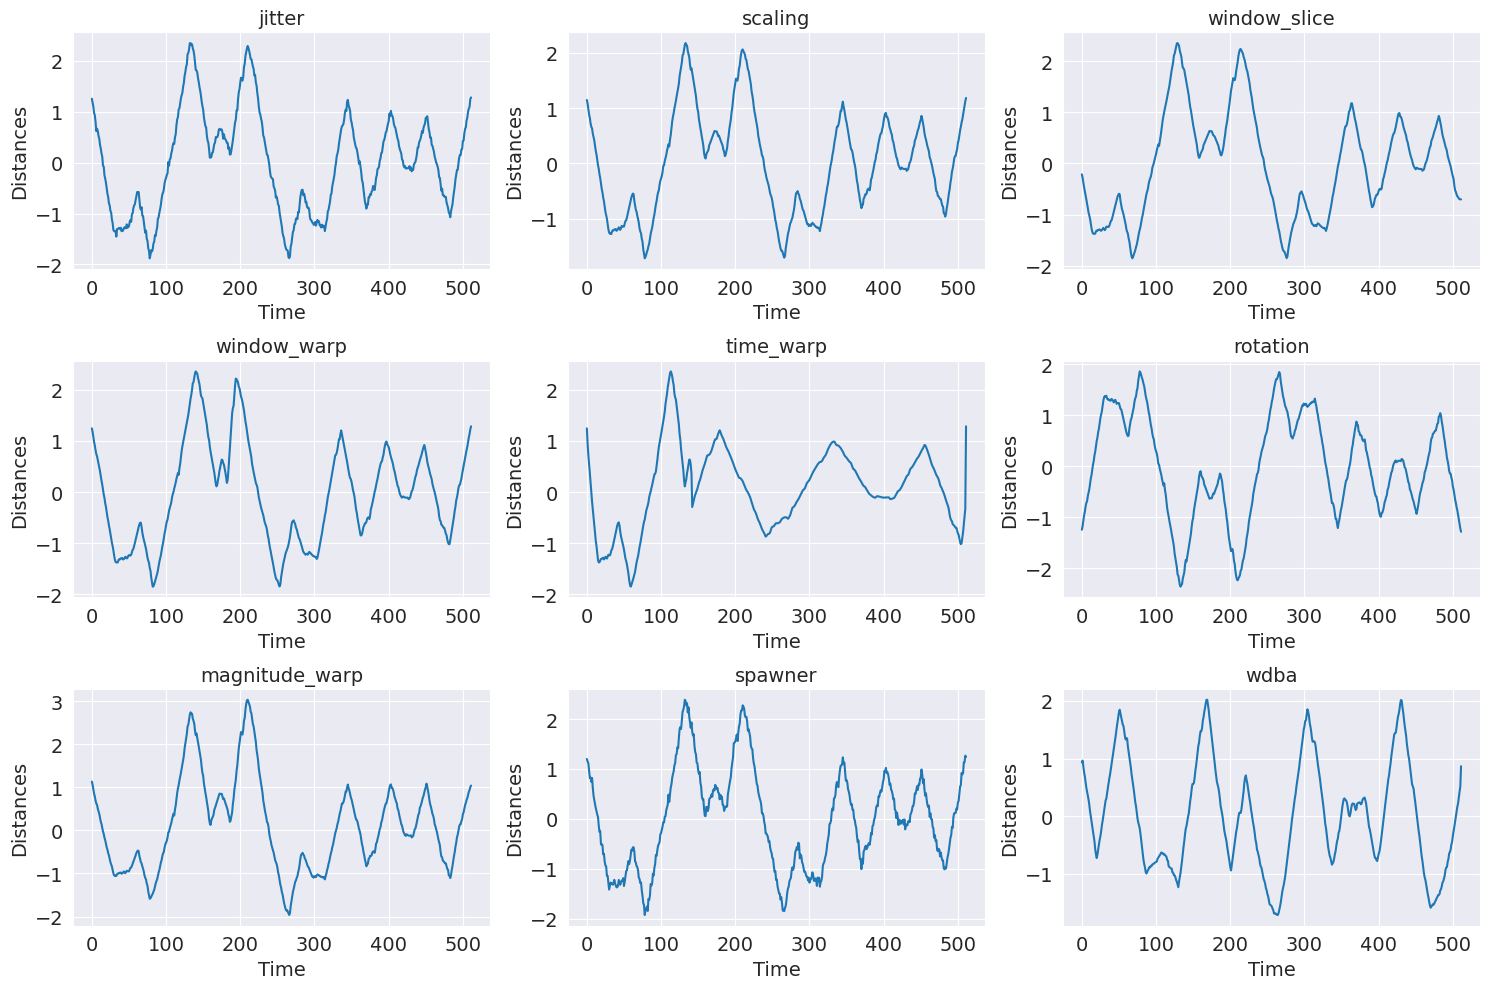

In [15]:
import seaborn as sns
augmentations = [(jitter, "jitter"), (scaling, "scaling"), (window_slice, "window_slice"),
                 (window_warp, "window_warp"), (time_warp, "time_warp"), (rotation, "rotation"),
                 (magnitude_warp, "magnitude_warp")]
augmentations_need_labels = [(spawner, "spawner"), (wdba, "wdba")]
transformation_names = ["jitter", "scaling", "window_slice", "window_warp",
                        "time_warp", "rotation", "magnitude_warp", "spawner", "wdba"]
for dataset_name in short_dataset_name_list[1:2]:
    dataset_path = dirname("./Example_Datasets/UCRArchive_2018/")
    X_train, y_train, X_test, y_test = TSC_data_loader(dataset_path, dataset_name)
    transformed_data = []
    for augmentation in augmentations:
        fun = augmentation[0]
        augmentation_name = augmentation[1]
        X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
        X_train_funced = fun(X_train_reshaped)
        X_train_funced = X_train_funced.reshape((X_train_funced.shape[0], X_train_funced.shape[1]))
        X_train_funced = X_train_funced.astype(np.float32)
        transformed_data.append(X_train_funced)
    
    for augmentation in augmentations_need_labels:
        fun = augmentation[0]
        augmentation_name = augmentation[1]
        X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
        X_train_funced = fun(X_train_reshaped, y_train)
        X_train_funced = X_train_funced.reshape((X_train_funced.shape[0], X_train_funced.shape[1]))
        X_train_funced = X_train_funced.astype(np.float32)
        transformed_data.append(X_train_funced)

    rows, cols = 3, 3

    # Create the subplots
    sns.set_style('darkgrid')
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 10))

    # Loop over all axes to plot random data
    for i in range(rows):
        for j in range(cols):
            # Generate random data
            plot_id = 3*i+j
            data = transformed_data[plot_id][0]
            transformation_name = transformation_names[plot_id]

            # Plot on the current axis
            axes[i, j].plot(data)
            axes[i, j].set_title(transformation_name, fontsize=14)
            axes[i, j].tick_params(axis='x', labelsize=14)  # Adjust xticks size
            axes[i, j].tick_params(axis='y', labelsize=14)  # Adjust xticks size
            axes[i, j].set_xlabel('Time', fontsize=14) 
            axes[i, j].set_ylabel('Distances', fontsize=14) 

    # Adjust layout to prevent overlapping
    plt.tight_layout()

    # Display the plots
    plt.show()